# 2. CLASSIFICATION

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import random
import os

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import classification_report

In [2]:
def seed_everything(seed=42):
    """"Seed everything.
    """   
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
seed_everything()

In [13]:
def classification_metric(y_true, y_pred):
    # labs = ["high_rain", "low_rain", "no_rain"]
    # f1 = np.round(f1_score(y_true, y_pred, labels = labs, average = "macro"), 3)
    # class_recall = np.round(recall_score(y_true, y_pred, labels = labs, average = None), 3)
    # total_recall = np.round(recall_score(y_true, y_pred, labels = labs, average = "macro"), 3)
    # acc = np.round(accuracy_score(y_true, y_pred), 3)
    # precision = np.round(precision_score(y_true, y_pred, labels = labs, average = None), 3)
    print("Confusion matrix : ")
    table = pd.crosstab(y_true, y_pred, dropna = False)
    print(table)
    print(classification_report(y_true, y_pred))
    # table.columns = table.columns.astype(str)
    # table["recall"] = class_recall[:len(table.index)]
    # table["precision"] = precision[:len(table.index)]
    # print("The confusion matrix ")
    # print(table)
    # print("The prediction accuracy: ", acc)
    # print("The f1-score : ", f1)
    # print("The recall-score : ", total_recall)


In [4]:
train_set = pd.read_csv("data/train_set.txt",sep = ' ')
test_set = pd.read_csv("data/test_set.txt",sep = ' ')

In [6]:
train_set

,ff,t,td,hu,dd,precip_log,ws_arome,p3031_arome,u10_arome,v10_arome,...,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
1,-0.086213,1.164777,0.910535,-0.798235,0.520054,-0.820399,-0.036595,0.529785,0.801953,0.400758,...,0,0,0,1,0,0,0,0,0,0
2,-0.215296,-1.471529,-1.661333,-0.454718,0.695888,0.078895,-0.257664,1.323143,0.556898,-0.888709,...,1,0,0,0,0,0,0,0,0,0
4,-1.468680,0.129100,-0.187510,-1.056853,0.129012,-0.820399,-1.317523,-0.827820,-0.605044,-0.693706,...,0,0,1,0,0,0,0,0,0,0
5,1.028401,-1.238485,-1.421240,-0.491033,1.022205,0.269433,0.464623,1.063498,1.186435,-0.717044,...,0,0,0,0,0,0,0,0,0,0
6,-1.465538,-1.273800,-1.288810,0.075769,-0.850480,-0.612447,-1.277939,-0.588190,-0.432199,0.107395,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,-1.530734,-0.516512,-0.138244,1.196123,-1.643351,-0.820399,-1.372398,-0.675518,-0.807684,-0.353231,...,0,0,0,0,0,0,0,0,1,0
727,-1.169931,1.010201,0.849969,-0.528329,-0.517151,-0.436627,-0.937395,-1.045143,-0.647040,-0.734017,...,0,0,0,0,0,1,0,0,0,0
728,0.070624,1.223185,0.604995,-1.875404,0.563203,-0.820399,-0.361343,0.433055,-0.257686,0.071419,...,0,0,1,0,0,0,0,0,0,0
729,-1.387512,1.472917,1.344347,-0.480237,-1.532241,-0.612447,-1.125196,-1.264025,-1.094799,0.101478,...,0,0,0,1,0,0,0,0,0,0


In [5]:
X_train = pd.DataFrame(train_set).copy()
del X_train['rain']
del X_train['rain_class']
del X_train['rain_log']

X_test = pd.DataFrame(test_set).copy()
del X_test['rain']
del X_test['rain_class']
del X_test['rain_log']

In [6]:
train_set['rain_class'] = train_set['rain_class'].astype("category")
test_set['rain_class'] = test_set['rain_class'].astype("category")

In [7]:
Y_train = train_set['rain']
Y_train_log = train_set['rain_log']

Y_test = test_set['rain']
Y_test_log = test_set['rain_log']

In [8]:
Y_train_class = train_set['rain_class']
Y_test_class = test_set['rain_class']


In [10]:
X_train.head()

,ff,t,td,hu,dd,precip_log,ws_arome,p3031_arome,u10_arome,v10_arome,...,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
1,-0.086213,1.164777,0.910535,-0.798235,0.520054,-0.820399,-0.036595,0.529785,0.801953,0.400758,...,0,0,0,1,0,0,0,0,0,0
2,-0.215296,-1.471529,-1.661333,-0.454718,0.695888,0.078895,-0.257664,1.323143,0.556898,-0.888709,...,1,0,0,0,0,0,0,0,0,0
4,-1.468680,0.129100,-0.187510,-1.056853,0.129012,-0.820399,-1.317523,-0.827820,-0.605044,-0.693706,...,0,0,1,0,0,0,0,0,0,0
5,1.028401,-1.238485,-1.421240,-0.491033,1.022205,0.269433,0.464623,1.063498,1.186435,-0.717044,...,0,0,0,0,0,0,0,0,0,0
6,-1.465538,-1.273800,-1.288810,0.075769,-0.850480,-0.612447,-1.277939,-0.588190,-0.432199,0.107395,...,0,0,0,0,0,0,0,0,0,1


## 2.1. K nearest neighbors

The completeness parameter `k` is optimised on a predefined grid by minimising the estimated error by cross-validation; scikit-learn offers many cross-validation options. 

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
# Optimisation of k
param_grid = [{"n_neighbors": list(range(1, 20))}]
knn = GridSearchCV(KNeighborsClassifier(weights = "distance"), scoring = "accuracy", param_grid = param_grid, cv=10, n_jobs=-1, refit = True)
knnOpt = knn.fit(X_train, Y_train_class)  
# optimal parameter
# knnOpt.best_params_["n_neighbors"]
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (knnOpt.best_score_, knnOpt.best_params_))

Best Mean cross-validated accuracy = 0.540000, Best parameter = {'n_neighbors': 18}


The prediction accuracy in the test set

In [13]:
# Estimation of the prediction accuracy on the test sample
print("Prediction accuracy in the test sample : ", knnOpt.score(X_test, Y_test_class))


Prediction accuracy in the test sample :  0.5072463768115942


In [14]:
# Prediction of the test sample
y_hat_class = knnOpt.predict(X_test)
classification_metric(Y_test_class, y_hat_class)
# print("Accuracy score =", accuracy_score(y_true = Y_test_class, y_pred = y_hat_class))

# # confusion matrix
# table = pd.crosstab(y_hat_class, Y_test_class)
# print("Confusion matrix")
# print(table)

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          20        12        1
low_rain           11        37       10
no_rain            11        23       13
              precision    recall  f1-score   support

   high_rain       0.48      0.61      0.53        33
    low_rain       0.51      0.64      0.57        58
     no_rain       0.54      0.28      0.37        47

    accuracy                           0.51       138
   macro avg       0.51      0.51      0.49       138
weighted avg       0.51      0.51      0.49       138



## 2.2. Decision tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
# Optimisation of shaft depth
param_grid = [{"max_depth": range(2,10), "min_samples_split" : range(2,10), "min_samples_leaf": range(1,5) }]
tree = GridSearchCV(DecisionTreeClassifier(max_features = 'auto', min_impurity_decrease = 1e-3, random_state = 42), scoring = "accuracy", param_grid = param_grid, cv=10, n_jobs=-1, refit = True)
treeOpt = tree.fit(X_train, Y_train_class)
# Optimal parameter
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (treeOpt.best_score_, treeOpt.best_params_))

Best Mean cross-validated accuracy = 0.512727, Best parameter = {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [16]:
# Estimation of the prediction error on the test sample
treeOpt.score(X_test, Y_test_class)

0.4855072463768116

In [17]:
# Prediction of the test sample
y_hat_class = treeOpt.predict(X_test)
classification_metric(Y_test_class, y_hat_class)

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          14        17        2
low_rain            6        39       13
no_rain             4        29       14
              precision    recall  f1-score   support

   high_rain       0.58      0.42      0.49        33
    low_rain       0.46      0.67      0.55        58
     no_rain       0.48      0.30      0.37        47

    accuracy                           0.49       138
   macro avg       0.51      0.46      0.47       138
weighted avg       0.50      0.49      0.47       138



    The `low_rain` class seems to be difficult to predict!

## 2.3. Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier 
# Parameters' definitions
forest = RandomForestClassifier(n_estimators = 500, 
   criterion='gini', max_depth=None,
   min_samples_split=2, min_samples_leaf=1, 
   max_features='auto', max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# Training
rfFit = forest.fit(X_train,Y_train_class)
# Out-of-bag error on the train sample
print(1 - rfFit.oob_score_)
# Out-of-bag error on the test sample
print(1 - rfFit.score(X_test,Y_test_class))

0.4545454545454546
0.5144927536231885


Hyper parameters tunning by cross validation

In [19]:
param = [{"n_estimators" : range(200, 500, 100) , "max_features": range(2,5), "max_depth" : range(10, 20, 2) }]
rf = GridSearchCV(RandomForestClassifier(random_state=42, criterion="entropy"),
        param, cv = 5, n_jobs=-1)
rfOpt = rf.fit(X_train, Y_train_class)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (rfOpt.best_score_, rfOpt.best_params_))

Best Mean cross-validated accuracy = 0.545455, Best parameter = {'max_depth': 12, 'max_features': 4, 'n_estimators': 300}


In [20]:
# Prediction of the test sample
y_pred_test = treeOpt.predict(X_test)
classification_metric(Y_test_class, y_pred_test)

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          14        17        2
low_rain            6        39       13
no_rain             4        29       14
              precision    recall  f1-score   support

   high_rain       0.58      0.42      0.49        33
    low_rain       0.46      0.67      0.55        58
     no_rain       0.48      0.30      0.37        47

    accuracy                           0.49       138
   macro avg       0.51      0.46      0.47       138
weighted avg       0.50      0.49      0.47       138



### Gradient Boosting applying to Random Forest

In [21]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

In [22]:
from xgboost import XGBRFClassifier

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# define the model
model = XGBRFClassifier(n_estimators = 500, subsample = 0.99, random_state = 42, metric = "accuracy", n_jobs = -1)

In [ ]:
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_train, Y_train_class, scoring='accuracy', cv = cv, n_jobs=-1)
# report performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:

[14:49:06] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:49:06] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.

[14:49:06] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:49:06] WARNIN

/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:22] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:

[14:49:22] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:49:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:49:22] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:24] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:49:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:36] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:49:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:49:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:38] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:38] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:49:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:41] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:49:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:52] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:49:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:49:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:55] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:49:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:56] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:57] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:50:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror

/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:11] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:11] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:12] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:50:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:15] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:50:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror

/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:

[14:50:28] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:50:28] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:29] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:50:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:33] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:50:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:50:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror

/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:

[14:50:46] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:50:46] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:47] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:50:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:50:49] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:50:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:00] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:51:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:04] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:51:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[14:51:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean Accuracy: 0.525 (0.052)


/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [ ]:
model.fit(X_train, Y_train_class)
y_pred_test = model.predict(X_test)

classification_metric(Y_test_class, y_pred_test)

[14:51:12] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          18        13        2
low_rain           11        35       12
no_rain             8        21       18
              precision    recall  f1-score   support

   high_rain       0.49      0.55      0.51        33
    low_rain       0.51      0.60      0.55        58
     no_rain       0.56      0.38      0.46        47

    accuracy                           0.51       138
   macro avg       0.52      0.51      0.51       138
weighted avg       0.52      0.51      0.51       138



/usr/local/insa/anaconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


## 2.4. Support Vector Machine

### 2.4.1. Linear SVM 

Optimisation of C - Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
param=[{"C": np.linspace(0.01, 0.1, 10) }]
svm= GridSearchCV(LinearSVC(), param, cv=10, n_jobs = -1, scoring = "accuracy")
svmLinOpt=svm.fit(X_train, Y_train_class)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svmLinOpt.best_score_,svmLinOpt.best_params_))

Best Mean cross-validated accuracy = 0.547273, Best parameter = {'C': 0.06000000000000001}


In [ ]:
(Y_test_class == 'no_rain').sum()

47

In [ ]:
# Prediction of the test sample
y_pred_test = svmLinOpt.predict(X_test)
classification_metric(Y_test_class, y_pred_test)

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          25         7        1
low_rain           11        36       11
no_rain             9        20       18
              precision    recall  f1-score   support

   high_rain       0.56      0.76      0.64        33
    low_rain       0.57      0.62      0.60        58
     no_rain       0.60      0.38      0.47        47

    accuracy                           0.57       138
   macro avg       0.58      0.59      0.57       138
weighted avg       0.58      0.57      0.56       138



    It seems that with the linear kernel, the results is quite good comparing to other methods

### 2.4.2. SVM with polynomial kernels

By default, we take polynomial of degree 3

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param = [{"C":np.linspace(0.75,1.25,10),"gamma":np.linspace(0.01, 0.1, 10) , "coef0": np.linspace(0, 3, 5) }]
svm = GridSearchCV(SVC(kernel="poly"),param,cv=10,n_jobs=-1, scoring = "accuracy")
svmPolyOpt=svm.fit(X_train, Y_train_class)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svmPolyOpt.best_score_, svmPolyOpt.best_params_))

Best Mean cross-validated accuracy = 0.549091, Best parameter = {'C': 0.8055555555555556, 'coef0': 2.25, 'gamma': 0.030000000000000006}


In [ ]:
# Prediction of the test sample
y_pred_test = svmPolyOpt.predict(X_test)
classification_metric(Y_test_class, y_pred_test)

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          20        12        1
low_rain           11        36       11
no_rain             8        26       13
              precision    recall  f1-score   support

   high_rain       0.51      0.61      0.56        33
    low_rain       0.49      0.62      0.55        58
     no_rain       0.52      0.28      0.36        47

    accuracy                           0.50       138
   macro avg       0.51      0.50      0.49       138
weighted avg       0.50      0.50      0.49       138



Let's test for degree 2

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param=[{"C" : np.linspace(0.75,1.25,10),"gamma":np.linspace(0.01, 0.1, 10), "coef0":np.linspace(0, 3, 5) }]
svm= GridSearchCV(SVC(kernel="poly",degree =2),param,cv=10,n_jobs=-1,scoring = "accuracy")
svmPoly2Opt=svm.fit(X_train, Y_train_class)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svmPoly2Opt.best_score_,svmPoly2Opt.best_params_))

Best Mean cross-validated accuracy = 0.545455, Best parameter = {'C': 0.8055555555555556, 'coef0': 1.5, 'gamma': 0.08}


In [ ]:
# Prediction of the test sample
y_pred_test= svmPoly2Opt.predict(X_test)
classification_metric(Y_test_class, y_pred_test)

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          20        12        1
low_rain           12        34       12
no_rain             8        23       16
              precision    recall  f1-score   support

   high_rain       0.50      0.61      0.55        33
    low_rain       0.49      0.59      0.54        58
     no_rain       0.55      0.34      0.42        47

    accuracy                           0.51       138
   macro avg       0.51      0.51      0.50       138
weighted avg       0.51      0.51      0.50       138



### 2.4.3. SVM with radial kernel

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param=[{"C" : np.linspace(1,1.25,10),"gamma":np.linspace(0.05, 0.15, 10)}]
svm= GridSearchCV(SVC(kernel="rbf"), param, cv=10, n_jobs=-1,scoring = "accuracy")
svmRadOpt=svm.fit(X_train, Y_train_class)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svmRadOpt.best_score_,svmRadOpt.best_params_))

Best Mean cross-validated accuracy = 0.565455, Best parameter = {'C': 1.25, 'gamma': 0.09444444444444444}


In [ ]:
# Prediction of the test sample
y_pred_test = svmRadOpt.predict(X_test)
classification_metric(Y_test_class, y_pred_test)

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          21        11        1
low_rain           10        39        9
no_rain            10        26       11
              precision    recall  f1-score   support

   high_rain       0.51      0.64      0.57        33
    low_rain       0.51      0.67      0.58        58
     no_rain       0.52      0.23      0.32        47

    accuracy                           0.51       138
   macro avg       0.52      0.51      0.49       138
weighted avg       0.52      0.51      0.49       138



### 2.4.3. SVM with sigmoid kernel

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param=[{"C":[0.1,0.4,0.5,0.6,0.8,1,1.2,1.4,1.6,2],"gamma":np.array(range(1,11))/100, "coef0":np.array(range(1,11))/10}]
svm= GridSearchCV(SVC(kernel="sigmoid"),param,cv=10,n_jobs=-1,scoring = "accuracy")
svmSigOpt=svm.fit(X_train, Y_train_class)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svmSigOpt.best_score_,svmSigOpt.best_params_))

Best Mean cross-validated accuracy = 0.516364, Best parameter = {'C': 0.4, 'coef0': 0.1, 'gamma': 0.05}


In [ ]:
# Prediction of the test sample
y_pred_test = svmSigOpt.predict(X_test)
classification_metric(Y_test_class, y_pred_test)

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          26         7        0
low_rain           12        42        4
no_rain             8        35        4
              precision    recall  f1-score   support

   high_rain       0.57      0.79      0.66        33
    low_rain       0.50      0.72      0.59        58
     no_rain       0.50      0.09      0.15        47

    accuracy                           0.52       138
   macro avg       0.52      0.53      0.47       138
weighted avg       0.52      0.52      0.46       138



## 2.5. Neural Network

### 2.5.1 One hidden layer neural network

In [ ]:
from sklearn.neural_network import MLPClassifier

Firstly, we fit an one-hidden layer neural network with ReLU activation in the hidden layer and the softmax activation for the out put layer, and the log-loss function. We use here the default configuration for the optimisation task.

In [ ]:
nnet1 = MLPClassifier(hidden_layer_sizes = (3), random_state = 42, max_iter = 1500)
nnet1.fit(X_train, Y_train_class)

MLPClassifier(hidden_layer_sizes=3, max_iter=1500, random_state=42)

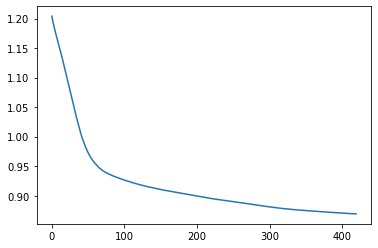

In [ ]:
plt.plot(nnet1.loss_curve_)

Training accuracy

In [ ]:
y_pred = nnet1.predict(X_train)

classification_metric(Y_train_class, y_pred)

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          90        60        5
low_rain           34       179       21
no_rain             9       100       52
              precision    recall  f1-score   support

   high_rain       0.68      0.58      0.62       155
    low_rain       0.53      0.76      0.62       234
     no_rain       0.67      0.32      0.44       161

    accuracy                           0.58       550
   macro avg       0.62      0.56      0.56       550
weighted avg       0.61      0.58      0.57       550



Test accuracy

In [ ]:
y_pred_test = nnet1.predict(X_test)

classification_metric(Y_test_class, y_pred_test)

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          24         8        1
low_rain           10        36       12
no_rain             8        28       11
              precision    recall  f1-score   support

   high_rain       0.57      0.73      0.64        33
    low_rain       0.50      0.62      0.55        58
     no_rain       0.46      0.23      0.31        47

    accuracy                           0.51       138
   macro avg       0.51      0.53      0.50       138
weighted avg       0.50      0.51      0.49       138



    Since the training accuracy is low, we can not expect that the test accuracy is good. It means that this model does fit with the data or the optimisation process did not minimize the loss function since it stopped around 500 iterations

We'll use cross validation for searching the optimal number of neurones in the hidden layer and the learning rate for optimisation process

In [ ]:
param_grid = [{"hidden_layer_sizes" : [(3,),(4,),(5,),(6,), (7,)], "early_stopping" : [True, False], "alpha" : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]}]

nnet1_cv = GridSearchCV(MLPClassifier(max_iter = 1500, random_state = 42), param_grid, cv = 5, n_jobs=-1, return_train_score = True)
nnet1_cv.fit(X_train, Y_train_class)

print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (nnet1_cv.best_score_, nnet1_cv.best_params_))

/usr/local/insa/anaconda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/insa/anaconda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Mean cross-validated accuracy = 0.527273, Best parameter = {'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (5,)}


In [ ]:
y_pred = nnet1_cv.predict(X_train)

classification_metric(Y_train_class, y_pred)

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain         106        36       13
low_rain           31       172       31
no_rain            10        73       78
              precision    recall  f1-score   support

   high_rain       0.72      0.68      0.70       155
    low_rain       0.61      0.74      0.67       234
     no_rain       0.64      0.48      0.55       161

    accuracy                           0.65       550
   macro avg       0.66      0.63      0.64       550
weighted avg       0.65      0.65      0.64       550



In [ ]:
y_pred_test = nnet1_cv.predict(X_test)

classification_metric(Y_test_class, y_pred_test)

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          25         7        1
low_rain           12        33       13
no_rain             8        24       15
              precision    recall  f1-score   support

   high_rain       0.56      0.76      0.64        33
    low_rain       0.52      0.57      0.54        58
     no_rain       0.52      0.32      0.39        47

    accuracy                           0.53       138
   macro avg       0.53      0.55      0.53       138
weighted avg       0.53      0.53      0.52       138



We can see that the loss function is almost reached the minimum but the prediction accuracy is still arounded $50$ percents. It means that this model does not fit well the data. We will try with more sophisticated models in the next sections

### 2.5.2. Multilayers Neural Network

    Remark that if we just fit a sophisticated model with many parameters (weights and biases), we can get very high performance on the training set. But unfortunately, we can get a worse performance on the test set
    and the generalization of the model is very bad. This is the **overfitting** phenomenon

In [ ]:
nnet_of = MLPClassifier(hidden_layer_sizes = (20, 25 , 15, 15, 10, 5), random_state = 42, max_iter = 1500, alpha = 0.1, activation = "relu", early_stopping = False, n_iter_no_change = 75)
nnet_of.fit(X_train, Y_train_class)


MLPClassifier(alpha=0.1, hidden_layer_sizes=(20, 25, 15, 15, 10, 5),
              max_iter=1500, n_iter_no_change=75, random_state=42)

Training accuracy :  1.0


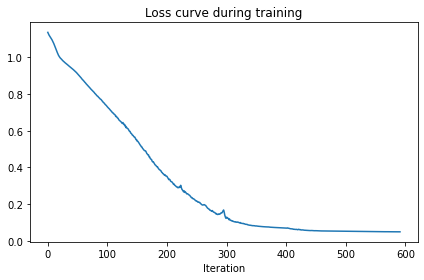

In [ ]:
print("Training accuracy : ", nnet_of.score(X_train, Y_train_class))
plt.figure(figsize=(6,4))
plt.plot(nnet_of.loss_curve_)
plt.title("Loss curve during training")
plt.xlabel("Iteration")
plt.tight_layout()
plt.savefig("loss_nn_overfit.pdf")

In [ ]:
y_pred_test = nnet_of.predict(X_test)

classification_metric(Y_test_class, y_pred_test)

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          23         7        3
low_rain           16        25       17
no_rain            10        22       15
              precision    recall  f1-score   support

   high_rain       0.47      0.70      0.56        33
    low_rain       0.46      0.43      0.45        58
     no_rain       0.43      0.32      0.37        47

    accuracy                           0.46       138
   macro avg       0.45      0.48      0.46       138
weighted avg       0.45      0.46      0.45       138



We try here to find a Neural Network which can generalize the data 

Training accuracy :  0.5454545454545454


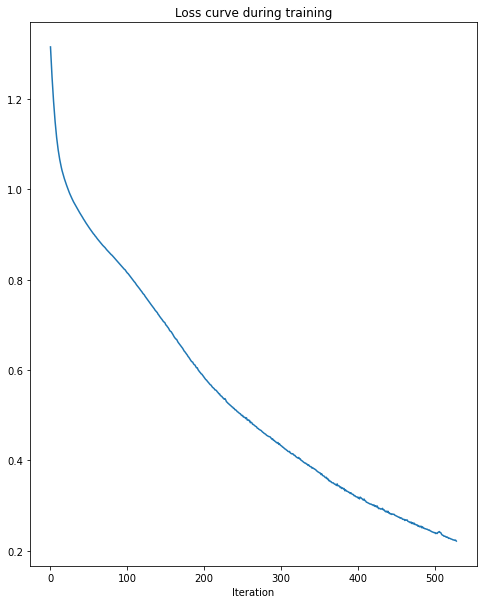

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          25         7        1
low_rain           11        42        5
no_rain             9        27       11
              precision    recall  f1-score   support

   high_rain       0.56      0.76      0.64        33
    low_rain       0.55      0.72      0.63        58
     no_rain       0.65      0.23      0.34        47

    accuracy                           0.57       138
   macro avg       0.59      0.57      0.54       138
weighted avg       0.59      0.57      0.53       138



In [ ]:
nnet = MLPClassifier(hidden_layer_sizes = (15, 10, 10, 8, 8, 5), random_state = 42, max_iter = 1500, alpha = 0.1, activation = "tanh", early_stopping = True, n_iter_no_change = 500)
nnet.fit(X_train, Y_train_class)

print("Training accuracy : ", nnet.score(X_train, Y_train_class))
plt.plot(nnet.loss_curve_)
plt.title("Loss curve during training")
plt.xlabel("Iteration")
plt.show()
y_pred_test = nnet.predict(X_test)

classification_metric(Y_test_class, y_pred_test)

## 2.6. Gaussian Process Classifier

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern


In [ ]:
GPC = GaussianProcessClassifier(kernel = 0.5*RBF(3.0), random_state = 42, multi_class = "one_vs_rest")
GPC.fit(X_train, Y_train_class)
print(GPC.score(X_train, Y_train_class))
print(GPC.score(X_test, Y_test_class))

0.5981818181818181
0.5144927536231884


In [ ]:
GPC = GaussianProcessClassifier(kernel = Matern(3.0, nu = 1.5), random_state = 42, multi_class = "one_vs_rest")
GPC.fit(X_train, Y_train_class)
print(GPC.score(X_train, Y_train_class))
print(GPC.score(X_test, Y_test_class))

0.6218181818181818
0.5217391304347826


# 3. REGRESSION AND CLASSIFICATION USING REGRESSION

## 3.1. Evaluation Metrics used in regression problem: MSE, MAPE et R2-Score

In [14]:
def regression_metric(y_true, y_pred):
    mape = MAPE(y_true, y_pred)
    mse = MSE(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = MAE(y_true, y_pred)

    print("Mean squared error : ", np.round(mse, 2))
    print("Mean absolute error : ", np.round(mae, 2))
    print("Mean absolute percentage error : ", np.round(mape, 2))
    print("R2 - Score : ", np.round(r2, 2))

In [15]:
def to_class(rain, eps = 1e-3):
    myrain = (rain <= eps)*0 + (rain > eps)*(rain <= 2 )*1 + (rain > 2)*2
    myrain2 = myrain.astype('<U9')

    myrain2[myrain == 0] = 'no_rain'
    myrain2[myrain == 1] = 'low_rain'
    myrain2[myrain == 2] = 'high_rain'
    return myrain2

## 3.2.Linear regression without penalisation and without variable selection

### 3.2.1. With `rain`

In [16]:
from sklearn.linear_model import LinearRegression
regLin = LinearRegression().fit(X_train, Y_train)
y_pred = regLin.predict(X_test)

regression_metric(Y_test, y_pred)

Mean squared error :  21.31
Mean absolute error :  2.71
Mean absolute percentage error :  3012463523105789.0
R2 - Score :  0.18


We can evaluate the prediction accuracy for classification by comparing the results into class with `rain_class`

In [53]:
(29+24+8)/138

0.4420289855072464

In [17]:
y_pred_class = to_class(y_pred)

classification_metric(Y_test_class,y_pred_class)

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          29         2        2
low_rain           28        24        6
no_rain            21        18        8
              precision    recall  f1-score   support

   high_rain       0.37      0.88      0.52        33
    low_rain       0.55      0.41      0.47        58
     no_rain       0.50      0.17      0.25        47

    accuracy                           0.44       138
   macro avg       0.47      0.49      0.42       138
weighted avg       0.49      0.44      0.41       138



### 3.2.2. With `rain_log`

In [18]:
regLinLog = LinearRegression().fit(X_train, Y_train_log)

prevLog = regLinLog.predict(X_test)
prev = np.exp(prevLog) - 1

regression_metric(Y_test, prev)
classification_metric(Y_test_class, to_class(prev))

Mean squared error :  18.36
Mean absolute error :  2.06
Mean absolute percentage error :  1494003623307454.5
R2 - Score :  0.29
Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          23         8        2
low_rain           11        45        2
no_rain             7        38        2
              precision    recall  f1-score   support

   high_rain       0.56      0.70      0.62        33
    low_rain       0.49      0.78      0.60        58
     no_rain       0.33      0.04      0.08        47

    accuracy                           0.51       138
   macro avg       0.46      0.51      0.43       138
weighted avg       0.46      0.51      0.43       138



By using `rain_log`, the value of MSE is reduced

## 3.3. Penalized regression 

### 3.3.1. Penalisation Lasso

#### 3.3.1.1. With `rain`

We implement the Lasso regression with the default values

In [19]:
from sklearn import linear_model
regLasso = linear_model.Lasso()
regLasso.fit(X_train, Y_train)
prev = regLasso.predict(X_test)

regression_metric(Y_test, prev)
classification_metric(Y_test_class, to_class(prev))

Mean squared error :  22.87
Mean absolute error :  2.79
Mean absolute percentage error :  3322153815044801.5
R2 - Score :  0.12
Confusion matrix : 
col_0       high_rain  low_rain
rain_class                     
high_rain          32         1
low_rain           37        21
no_rain            28        19
              precision    recall  f1-score   support

   high_rain       0.33      0.97      0.49        33
    low_rain       0.51      0.36      0.42        58
     no_rain       0.00      0.00      0.00        47

    accuracy                           0.38       138
   macro avg       0.28      0.44      0.31       138
weighted avg       0.29      0.38      0.30       138



c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The penalisation parameter is optimized by the cross validation

In [20]:
from sklearn.model_selection import GridSearchCV
param = [{"alpha":np.linspace(0, 2, 200)}]
regLasso = GridSearchCV(linear_model.Lasso(), param_grid = param, scoring = "r2", cv = 5,n_jobs=-1)
regLassOpt = regLasso.fit(X_train, Y_train)
# Optimal parameter
regLassOpt.best_params_["alpha"]
print("Best R2 = %f, Best parameter = %s" % (regLassOpt.best_score_, regLassOpt.best_params_))

Best R2 = 0.200521, Best parameter = {'alpha': 0.1306532663316583}


Let's do some previsions with the optimized value of `lambda`

In [21]:
prev = regLassOpt.predict(X_test)
regression_metric(Y_test, prev)
classification_metric(Y_test_class, to_class(prev))

Mean squared error :  20.13
Mean absolute error :  2.48
Mean absolute percentage error :  2685508596512428.0
R2 - Score :  0.23
Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          28         4        1
low_rain           27        31        0
no_rain            19        25        3
              precision    recall  f1-score   support

   high_rain       0.38      0.85      0.52        33
    low_rain       0.52      0.53      0.53        58
     no_rain       0.75      0.06      0.12        47

    accuracy                           0.45       138
   macro avg       0.55      0.48      0.39       138
weighted avg       0.56      0.45      0.39       138



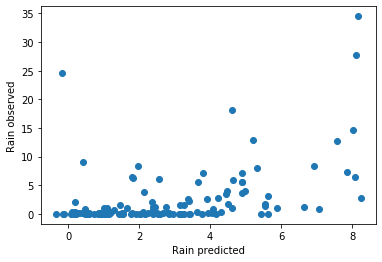

In [22]:
plt.plot(prev, Y_test,"o")
plt.xlabel("Rain predicted")
plt.ylabel("Rain observed")
plt.show()

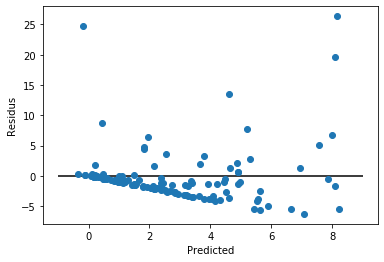

In [23]:
plt.plot(prev,Y_test - prev,"o")
plt.xlabel(u"Predicted")
plt.ylabel(u"Residus")
plt.hlines(0,-1,9)
plt.show()

In [24]:
# Coefficients
regLasso=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])
model_lasso=regLasso.fit(X_train,Y_train)
model_lasso.coef_

array([ 0.        , -0.37687198, -0.        ,  0.        , -0.        ,
        0.38776323,  0.        ,  0.        ,  0.54709915,  0.78792087,
       -0.        , -0.22947443, -0.        , -0.        , -0.90195728,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ])

In [25]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso retain " + str(sum(coef != 0)) + 
      " variables and delete " +  str(sum(coef == 0)))

Lasso retain 6 variables and delete 20


Text(0.5, 1.0, 'Lasso model coefficients')

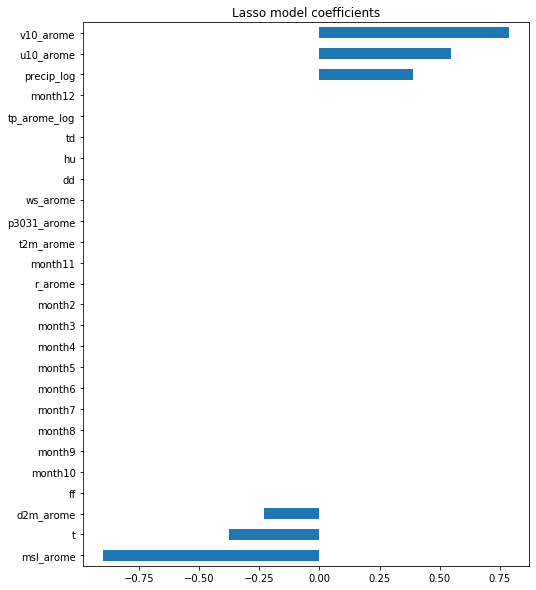

In [26]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Lasso model coefficients")

c:\Users\nguye\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2934564480574409, tolerance: 0.895025215909091
  positive,
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.55080072126839, tolerance: 0.7780063977272728
  positive,


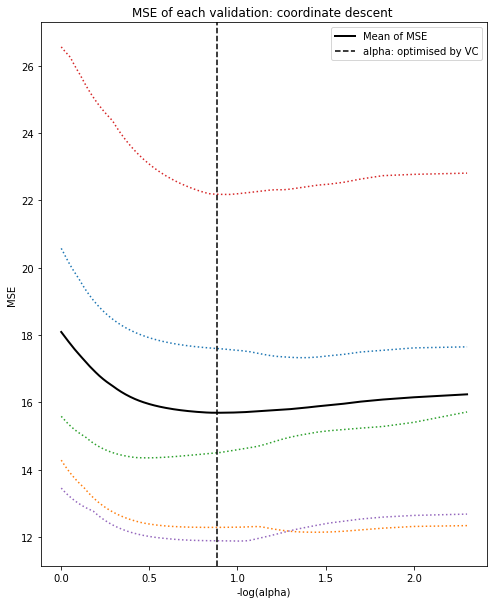

In [27]:
from sklearn.linear_model import LassoCV
model = LassoCV(cv=5, alphas=np.array(range(1,200,1))/200.,n_jobs=-1,random_state=42).fit(X_train,Y_train)
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
# ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Mean of MSE', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: optimised by VC')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('MSE')
plt.title('MSE of each validation: coordinate descent ')
plt.show()

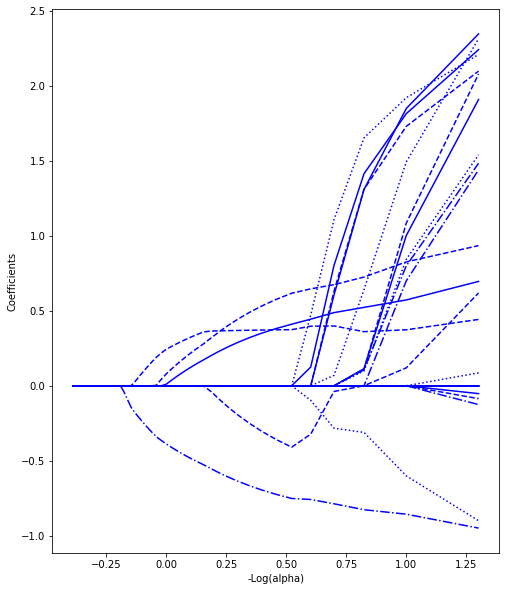

In [28]:
from itertools import cycle

from sklearn.linear_model import lasso_path
alphas_lasso, coefs_lasso, _ = lasso_path(X_train,Y_train, alphas=np.array(range(1,50,1))/20.,)


plt.figure()
ax = plt.gca()

styles = cycle(['-', '--', '-.', ':'])

neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, s in zip(coefs_lasso, styles):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, linestyle=s,c='b')
plt.xlabel('-Log(alpha)')
plt.ylabel('Coefficients')
plt.show()

#### 3.3.1.2. With `rain_log`

In [29]:
from sklearn.model_selection import GridSearchCV
param=[{"alpha": np.linspace(0, 2 , 200) }]

regLasso = GridSearchCV(linear_model.Lasso(), param_grid = param, scoring = "r2",cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(X_train, Y_train_log)
# optimal parameter 
regLassOpt.best_params_["alpha"]
print("Best R2 = %f, Best parameter = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))

Best R2 = 0.295246, Best parameter = {'alpha': 0.03015075376884422}


In [30]:
prevLog = regLassOpt.predict(X_test)
prev = np.exp(prevLog) -1

regression_metric(Y_test, prev)
classification_metric(Y_test_class, to_class(prev))

Mean squared error :  19.96
Mean absolute error :  2.02
Mean absolute percentage error :  1342118209495518.2
R2 - Score :  0.23
Confusion matrix : 
col_0       high_rain  low_rain
rain_class                     
high_rain          21        12
low_rain           10        48
no_rain             3        44
              precision    recall  f1-score   support

   high_rain       0.62      0.64      0.63        33
    low_rain       0.46      0.83      0.59        58
     no_rain       0.00      0.00      0.00        47

    accuracy                           0.50       138
   macro avg       0.36      0.49      0.41       138
weighted avg       0.34      0.50      0.40       138



c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.3.2. Penalisation Ridge

#### With `rain`

We implement the Ridge regression with the default values

In [31]:
from sklearn.linear_model import Ridge
regRidge = Ridge()
regRidge.fit(X_train, Y_train)
prev = regRidge.predict(X_test)

regression_metric(Y_test, prev)
classification_metric(Y_test_class, to_class(prev))

Mean squared error :  21.09
Mean absolute error :  2.66
Mean absolute percentage error :  2978857695046723.0
R2 - Score :  0.19
Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          29         2        2
low_rain           28        24        6
no_rain            20        19        8
              precision    recall  f1-score   support

   high_rain       0.38      0.88      0.53        33
    low_rain       0.53      0.41      0.47        58
     no_rain       0.50      0.17      0.25        47

    accuracy                           0.44       138
   macro avg       0.47      0.49      0.42       138
weighted avg       0.48      0.44      0.41       138



The penalisation parameter is optimized by the cross validation

In [74]:
from sklearn.model_selection import GridSearchCV
param=[{"alpha" : np.linspace(140, 145, 100)}]
regRidge = GridSearchCV(Ridge(),param_grid = param, scoring = "r2",cv=10,n_jobs=-1)
regRidOpt=regRidge.fit(X_train, Y_train)
# optimal parameter
regRidOpt.best_params_["alpha"]
print("Best R2 = %f, Best parameter = %s" % (regRidOpt.best_score_,regRidOpt.best_params_))

Best R2 = 0.181217, Best parameter = {'alpha': 140.05050505050505}


Let's do some previsions with the optimized value of `lambda`

In [75]:
prev = regRidOpt.predict(X_test)
regression_metric(Y_test, prev)
classification_metric(Y_test_class, to_class(prev))

Mean squared error :  20.31
Mean absolute error :  2.5
Mean absolute percentage error :  2734181685333767.0
R2 - Score :  0.22
Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          29         3        1
low_rain           27        31        0
no_rain            19        26        2
              precision    recall  f1-score   support

   high_rain       0.39      0.88      0.54        33
    low_rain       0.52      0.53      0.53        58
     no_rain       0.67      0.04      0.08        47

    accuracy                           0.45       138
   macro avg       0.52      0.49      0.38       138
weighted avg       0.54      0.45      0.38       138



In [76]:
# Coefficients
regRidge=linear_model.Ridge(alpha=regRidOpt.best_params_['alpha'])
model_ridge=regRidge.fit(X_train,Y_train)
model_ridge.coef_

array([ 0.00110532, -0.18285315, -0.15389393,  0.1651522 , -0.08972391,
        0.48351588,  0.0224198 ,  0.09717099,  0.5529149 ,  0.73598732,
       -0.10560912, -0.20018796, -0.1167771 , -0.09761594, -0.81023836,
        0.14847003,  0.12779397, -0.28033134, -0.12260699,  0.0658401 ,
       -0.05654105,  0.01236394, -0.14549736, -0.06987998,  0.14225015,
        0.10135434])

In [77]:
coef = pd.Series(model_ridge.coef_, index = X_train.columns)
print("Ridge retains " + str(sum(coef != 0)) + 
      " variables and deletes " +  str(sum(coef == 0)))

Ridge retains 26 variables and deletes 0


Text(0.5, 1.0, 'Ridge model coefficients')

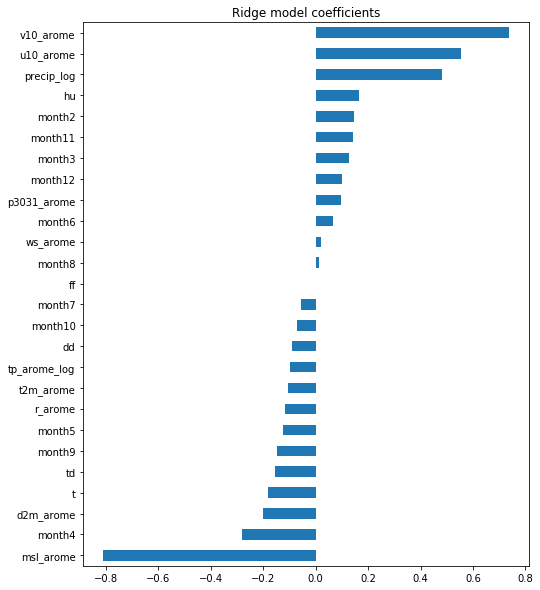

In [78]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Ridge model coefficients")

#### With `rain_log`

We implement the Ridge regression with the default values

In [79]:
from sklearn.linear_model import Ridge
regRidge_log = Ridge()
regRidge_log.fit(X_train, Y_train_log)
prev = regRidge_log.predict(X_test)
prev = np.exp(prev) - 1

regression_metric(Y_test, prev)
classification_metric(Y_test_class, to_class(prev))

Mean squared error :  18.55
Mean absolute error :  2.03
Mean absolute percentage error :  1456739163201788.8
R2 - Score :  0.29
Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          23         9        1
low_rain            9        49        0
no_rain             7        38        2
              precision    recall  f1-score   support

   high_rain       0.59      0.70      0.64        33
    low_rain       0.51      0.84      0.64        58
     no_rain       0.67      0.04      0.08        47

    accuracy                           0.54       138
   macro avg       0.59      0.53      0.45       138
weighted avg       0.58      0.54      0.45       138



The penalisation parameter is optimized by the cross validation

In [82]:
from sklearn.model_selection import GridSearchCV
param=[{"alpha" : np.linspace(45, 50, 100)}]
regRidge_log = GridSearchCV(Ridge(),param_grid = param, scoring = "r2",cv=10,n_jobs=-1)
regRidOpt_log=regRidge_log.fit(X_train, Y_train_log)
# optimal parameter
regRidOpt_log.best_params_["alpha"]
print("Best R2 = %f, Best parameter = %s" % (regRidOpt_log.best_score_,regRidOpt_log.best_params_))

Best R2 = 0.288807, Best parameter = {'alpha': 48.63636363636363}


Let's do some previsions with the optimized value of `lambda`

In [83]:
prev = regRidOpt_log.predict(X_test)
prev = np.exp(prev) - 1
regression_metric(Y_test, prev)
classification_metric(Y_test_class, to_class(prev))

Mean squared error :  19.37
Mean absolute error :  2.0
Mean absolute percentage error :  1388376374218653.8
R2 - Score :  0.25
Confusion matrix : 
col_0       high_rain  low_rain
rain_class                     
high_rain          22        11
low_rain            8        50
no_rain             5        42
              precision    recall  f1-score   support

   high_rain       0.63      0.67      0.65        33
    low_rain       0.49      0.86      0.62        58
     no_rain       0.00      0.00      0.00        47

    accuracy                           0.52       138
   macro avg       0.37      0.51      0.42       138
weighted avg       0.35      0.52      0.42       138



c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.3.3. Penalisation Elastic

#### With `rain`

In [37]:
from sklearn.linear_model import ElasticNet
regElastic = ElasticNet()
regElastic.fit(X_train,Y_train)
prev = regElastic.predict(X_test)

regression_metric(Y_test, prev)
classification_metric(Y_test_class, to_class(prev))

Mean squared error :  21.6
Mean absolute error :  2.67
Mean absolute percentage error :  3039005896868875.0
R2 - Score :  0.17
Confusion matrix : 
col_0       high_rain  low_rain
rain_class                     
high_rain          31         2
low_rain           29        29
no_rain            19        28
              precision    recall  f1-score   support

   high_rain       0.39      0.94      0.55        33
    low_rain       0.49      0.50      0.50        58
     no_rain       0.00      0.00      0.00        47

    accuracy                           0.43       138
   macro avg       0.29      0.48      0.35       138
weighted avg       0.30      0.43      0.34       138



c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
from sklearn.model_selection import GridSearchCV
param=[{"alpha":np.linspace(0,2,200)}]
regElastic = GridSearchCV(ElasticNet(), param, cv=5,n_jobs=-1)
regElasOpt=regElastic.fit(X_train, Y_train)
# optimal parameter
regElasOpt.best_params_["alpha"]
print("Best R2 = %f, Best parameter = %s" % (regElasOpt.best_score_, regElasOpt.best_params_))

Best R2 = 0.199723, Best parameter = {'alpha': 0.19095477386934673}


Let's do some previsions with the optimized value of `lambda`

In [39]:
prev=regElasOpt.predict(X_test)

regression_metric(Y_test, prev)
classification_metric(Y_test_class, to_class(prev))


Mean squared error :  20.2
Mean absolute error :  2.49
Mean absolute percentage error :  2695997953841904.0
R2 - Score :  0.22
Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          28         4        1
low_rain           27        31        0
no_rain            19        25        3
              precision    recall  f1-score   support

   high_rain       0.38      0.85      0.52        33
    low_rain       0.52      0.53      0.53        58
     no_rain       0.75      0.06      0.12        47

    accuracy                           0.45       138
   macro avg       0.55      0.48      0.39       138
weighted avg       0.56      0.45      0.39       138



In [40]:
# Coefficients
regElastic=linear_model.ElasticNet(alpha=regElasOpt.best_params_['alpha'])
model_elastic=regElastic.fit(X_train,Y_train)
model_elastic.coef_

array([ 0.        , -0.2883587 , -0.04571471,  0.        , -0.        ,
        0.43373162,  0.        ,  0.        ,  0.543652  ,  0.75824188,
       -0.04462993, -0.22759725,  0.        , -0.        , -0.84085592,
        0.        ,  0.        , -0.00232474, -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ])

In [41]:
coef = pd.Series(model_elastic.coef_, index = X_train.columns)
print("Elastic retains " + str(sum(coef != 0)) + 
      " variables and deletes " +  str(sum(coef == 0)))

Elastic retains 9 variables and deletes 17


Text(0.5, 1.0, 'Elastic model coefficients')

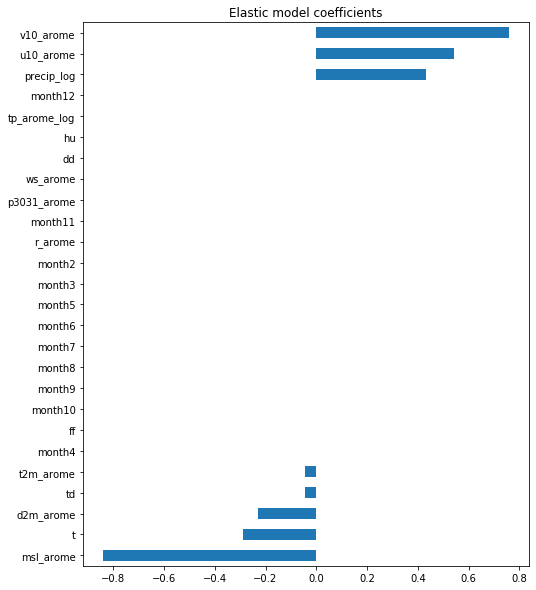

In [42]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Elastic model coefficients")

#### With `rain_log`

In [85]:
from sklearn.linear_model import ElasticNet
regElastic_log = ElasticNet()
regElastic_log.fit(X_train,Y_train_log)
prev = regElastic_log.predict(X_test)
prev = np.exp(prev) - 1

regression_metric(Y_test, prev)
classification_metric(Y_test_class, to_class(prev))

Mean squared error :  27.52
Mean absolute error :  2.44
Mean absolute percentage error :  1648054885416743.2
R2 - Score :  -0.06
Confusion matrix : 
col_0       low_rain
rain_class          
high_rain         33
low_rain          58
no_rain           47
              precision    recall  f1-score   support

   high_rain       0.00      0.00      0.00        33
    low_rain       0.42      1.00      0.59        58
     no_rain       0.00      0.00      0.00        47

    accuracy                           0.42       138
   macro avg       0.14      0.33      0.20       138
weighted avg       0.18      0.42      0.25       138



c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
from sklearn.model_selection import GridSearchCV
param = [{"alpha":np.linspace(0,2,200)}]
regElastic = GridSearchCV(ElasticNet(), param, cv=5,n_jobs=-1)
regElasOpt_log = regElastic.fit(X_train, Y_train_log)
# optimal parameter
regElasOpt_log.best_params_["alpha"]
print("Best R2 = %f, Best parameter = %s" % (regElasOpt_log.best_score_, regElasOpt_log.best_params_))

Best R2 = 0.294919, Best parameter = {'alpha': 0.05025125628140704}


Let's do some previsions with the optimized value of `lambda`

In [87]:
prev = regElasOpt_log.predict(X_test)
prev = np.exp(prev) - 1
 
regression_metric(Y_test, prev)
classification_metric(Y_test_class, to_class(prev))


Mean squared error :  19.95
Mean absolute error :  2.01
Mean absolute percentage error :  1340408312436011.0
R2 - Score :  0.23
Confusion matrix : 
col_0       high_rain  low_rain
rain_class                     
high_rain          21        12
low_rain            9        49
no_rain             3        44
              precision    recall  f1-score   support

   high_rain       0.64      0.64      0.64        33
    low_rain       0.47      0.84      0.60        58
     no_rain       0.00      0.00      0.00        47

    accuracy                           0.51       138
   macro avg       0.37      0.49      0.41       138
weighted avg       0.35      0.51      0.40       138



c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3.4. Generalized Linear Models (GLM)

### 3.4.1. Poisson Regression 

#### With `rain`

In [43]:
from sklearn.linear_model import PoissonRegressor
regPoisson = PoissonRegressor(alpha = 0, max_iter = 300)
regPoisson.fit(X_train, Y_train)
prev = regPoisson.predict(X_test)

regression_metric(Y_test, prev)
classification_metric(Y_test_class, to_class(prev))


Mean squared error :  19.13
Mean absolute error :  2.53
Mean absolute percentage error :  2402814485053989.5
R2 - Score :  0.26
Confusion matrix : 
col_0       high_rain  low_rain
rain_class                     
high_rain          26         7
low_rain           25        33
no_rain            15        32
              precision    recall  f1-score   support

   high_rain       0.39      0.79      0.53        33
    low_rain       0.46      0.57      0.51        58
     no_rain       0.00      0.00      0.00        47

    accuracy                           0.43       138
   macro avg       0.28      0.45      0.34       138
weighted avg       0.29      0.43      0.34       138



c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.4.2. Poisson Regression with penalty 

In [44]:
from sklearn.model_selection import GridSearchCV
param = [{"alpha":np.linspace(0,2,200)}]
regPoisson_l2 = GridSearchCV(PoissonRegressor(), param,cv=5,n_jobs=-1)
regPoiOpt_l2 = regPoisson_l2.fit(X_train, Y_train)
# optimal parameter
regPoiOpt_l2.best_params_["alpha"]
print("Best R2 = %f, Best parameter = %s" % (regPoiOpt_l2.best_score_,regPoiOpt_l2.best_params_))

Best R2 = 0.261372, Best parameter = {'alpha': 0.45226130653266333}


In [45]:
prev = regPoiOpt_l2.predict(X_test)

regression_metric(Y_test, prev)
classification_metric(np.array(Y_test_class), to_class(prev))

Mean squared error :  18.09
Mean absolute error :  2.42
Mean absolute percentage error :  2560581532952368.0
R2 - Score :  0.3
Confusion matrix : 
col_0      high_rain  low_rain
row_0                         
high_rain         26         7
low_rain          23        35
no_rain           16        31
              precision    recall  f1-score   support

   high_rain       0.40      0.79      0.53        33
    low_rain       0.48      0.60      0.53        58
     no_rain       0.00      0.00      0.00        47

    accuracy                           0.44       138
   macro avg       0.29      0.46      0.35       138
weighted avg       0.30      0.44      0.35       138



c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.4.3. Gamma Regression

In [46]:
from sklearn.linear_model import GammaRegressor

In [92]:
param = {"alpha" : np.linspace(0.1, 1, 15)}
gamma_reg_cv = GridSearchCV(GammaRegressor(max_iter=300), param_grid = param, cv = 10, n_jobs = -1)
gamma_reg = gamma_reg_cv.fit(X_train, Y_train + 1e-5)

print("The best parameter is ", gamma_reg_cv.best_params_)

y_pred = gamma_reg.predict(X_test)

regression_metric(Y_test, y_pred)
classification_metric(Y_test_class, to_class(y_pred))

The best parameter is  {'alpha': 0.1642857142857143}
Mean squared error :  18.12
Mean absolute error :  2.38
Mean absolute percentage error :  2241305606891828.5
R2 - Score :  0.3
Confusion matrix : 
col_0       high_rain  low_rain
rain_class                     
high_rain          27         6
low_rain           17        41
no_rain            10        37
              precision    recall  f1-score   support

   high_rain       0.50      0.82      0.62        33
    low_rain       0.49      0.71      0.58        58
     no_rain       0.00      0.00      0.00        47

    accuracy                           0.49       138
   macro avg       0.33      0.51      0.40       138
weighted avg       0.32      0.49      0.39       138



c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nguye\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.3.4. Tweedie Regression

In [48]:
from sklearn.linear_model import TweedieRegressor

In [93]:
param = {"power" : [0, 1, 1.5, 1.6, 1.7, 1.8, 2, 2.5, 3, 4], "alpha" : np.linspace(0.1, 1, 10)}
tw_cv = GridSearchCV(TweedieRegressor(link = "log", max_iter = 300), param_grid= param, cv = 10, n_jobs = -1, scoring = "neg_mean_absolute_error")
tw = tw_cv.fit(X_train, Y_train)
print("The best parameter is ", tw_cv.best_params_)
print("The best score is ", tw_cv.best_score_ )
y_pred = tw.predict(X_test)

regression_metric(Y_test, y_pred)
classification_metric(Y_test_class, to_class(y_pred))
classification_metric(Y_test_class, to_class(y_pred, eps = 0.5))

The best parameter is  {'alpha': 0.4, 'power': 1.8}
The best score is  -2.3144461668512224
Mean squared error :  17.52
Mean absolute error :  2.32
Mean absolute percentage error :  2306044107209599.0
R2 - Score :  0.33
Confusion matrix : 
col_0       high_rain  low_rain
rain_class                     
high_rain          27         6
low_rain           18        40
no_rain            11        36
              precision    recall  f1-score   support

   high_rain       0.48      0.82      0.61        33
    low_rain       0.49      0.69      0.57        58
     no_rain       0.00      0.00      0.00        47

    accuracy                           0.49       138
   macro avg       0.32      0.50      0.39       138
weighted avg       0.32      0.49      0.39       138

Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          27         4        2
low_rain           18        39        1
no_rain            11        32     

c:\Users\nguye\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
400 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nguye\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nguye\anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py", line 265, in fit
    family.__class__.__name__
ValueError: Some value(s) of y are out of the valid range for family TweedieDistribution

  warnings.warn(some_fits_failed_message, FitFailedWarning)
c:\Users\nguye\anaconda

## 3.5. SVM Regression

In [50]:
from sklearn.svm import LinearSVR

In [51]:
param = [{"C": np.linspace(0.01, 1, 200) }]
svr = GridSearchCV(LinearSVR(), param, cv=10, n_jobs = -1, scoring = "neg_mean_absolute_error")
svrLinOpt = svr.fit(X_train, Y_train)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svrLinOpt.best_score_, svrLinOpt.best_params_))

Best Mean cross-validated accuracy = -2.105254, Best parameter = {'C': 0.05477386934673367}


In [52]:
prev = svrLinOpt.predict(X_test)

regression_metric(Y_test, prev)
classification_metric(Y_test_class, to_class(prev))

Mean squared error :  23.23
Mean absolute error :  2.06
Mean absolute percentage error :  1033653042433951.0
R2 - Score :  0.11
Confusion matrix : 
col_0       high_rain  low_rain  no_rain
rain_class                              
high_rain          16        16        1
low_rain            5        47        6
no_rain             3        38        6
              precision    recall  f1-score   support

   high_rain       0.67      0.48      0.56        33
    low_rain       0.47      0.81      0.59        58
     no_rain       0.46      0.13      0.20        47

    accuracy                           0.50       138
   macro avg       0.53      0.47      0.45       138
weighted avg       0.51      0.50      0.45       138



## 3.6. Comparison of the performance 

In [15]:
perf_reg = pd.read_excel("./Performance_Regression.xlsx", header = 1)

In [16]:
perf_reg = perf_reg.drop(11)
perf_reg

,Model,MSE,MAE,MAPE,R2_Score,Accuracy,Avg_precision,Avg_recall,Avg_f1_score
0,lin_reg_rain,21.31,2.71,3.012464e+15,0.18,0.44,0.47,0.49,0.42
1,lin_reg_rain_log,18.36,2.06,1.494004e+15,0.29,0.51,0.46,0.51,0.43
2,lasso_rain,20.13,2.48,2.685509e+15,0.23,0.45,0.55,0.48,0.39
3,lasso_rain_log,19.96,2.02,1.342118e+15,0.23,0.50,0.36,0.49,0.41
4,ridge_rain,20.31,2.50,2.734182e+15,0.22,0.45,0.52,0.49,0.38
5,ridge_rain_log,18.55,2.03,1.456739e+15,0.29,0.54,0.59,0.53,0.45
6,elastic_net,20.20,2.49,2.695998e+15,0.22,0.45,0.55,0.48,0.39
7,elastic_net_log,19.95,2.01,1.340408e+15,0.23,0.51,0.37,0.49,0.41
8,poisson,19.13,2.53,2.402814e+15,0.26,0.43,0.28,0.45,0.34
9,poisson_pen,18.09,2.42,2.560582e+15,0.30,0.44,0.29,0.46,0.35


### 3.6.1. Regression Performance

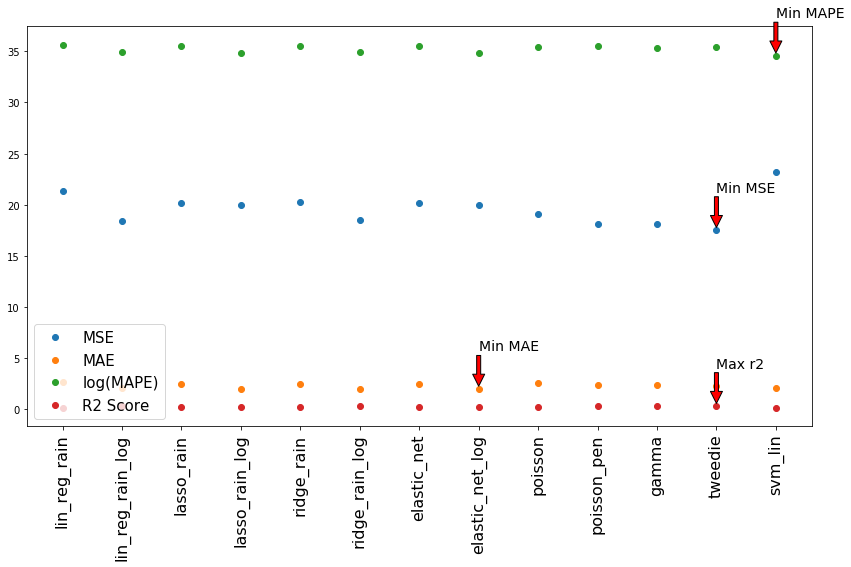

In [49]:
plt.figure(figsize=(12,8))

x = np.arange(13)

plt.plot(x, perf_reg["MSE"], "o", label = "MSE")
plt.plot(x, perf_reg["MAE"], "o", label = "MAE")
plt.plot(x, np.log(perf_reg["MAPE"]), "o", label = "log(MAPE)")
plt.plot(x, perf_reg["R2_Score"], "o", label = "R2 Score")

arg_min_mse, min_mse = np.argmin(perf_reg["MSE"]), np.min(perf_reg["MSE"])

plt.annotate(s = "Min MSE", xy = [arg_min_mse, min_mse + 0.25], 
        xytext = [arg_min_mse, min_mse + 3.75],
        arrowprops = dict(facecolor ='red', shrink = 0.001), fontsize = 14 )

arg_min_mae, min_mae = np.argmin(perf_reg["MAE"]), np.min(perf_reg["MAE"])

plt.annotate(s = "Min MAE", xy = [arg_min_mae, min_mae + 0.25], 
        xytext = [arg_min_mae, min_mae + 3.75],
        arrowprops = dict(facecolor ='red', shrink = 0.001), fontsize = 14 )

arg_min_mape, min_mape = np.argmin(perf_reg["MAPE"]), np.min(np.log(perf_reg["MAPE"]))

plt.annotate(s = "Min MAPE", xy = [arg_min_mape, min_mape + 0.25], 
        xytext = [arg_min_mape, min_mape + 3.75],
        arrowprops = dict(facecolor ='red', shrink = 0.001), fontsize = 14 )

arg_min_r2, min_r2 = np.argmax(perf_reg["R2_Score"]), np.max(perf_reg["R2_Score"])

plt.annotate(s = "Max r2", xy = [arg_min_r2, min_r2 + 0.25], 
        xytext = [arg_min_r2, min_r2 + 3.75],
        arrowprops = dict(facecolor ='red', shrink = 0.001), fontsize = 14 )

plt.xticks(x, list(perf_reg["Model"]), rotation ='vertical', fontsize = 16)
plt.legend(loc = 3, fontsize = 15)
plt.tight_layout()
plt.savefig("./Images/Reg_Performance.pdf")

### 3.6.2. Classification Performance

In [19]:
perf_class = pd.read_excel("./Performance_Regression.xlsx", header = 1)

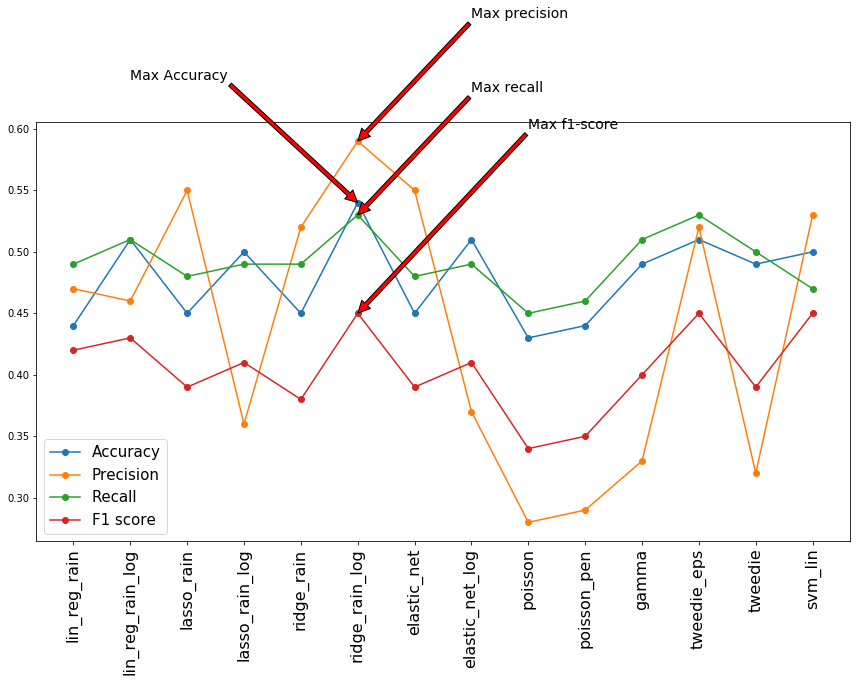

In [48]:
plt.figure(figsize=(12,10))

x = np.arange(14)

plt.plot(x, perf_class["Accuracy"], "-o", label = "Accuracy")
plt.plot(x, perf_class["Avg_precision"], "-o", label = "Precision")
plt.plot(x, perf_class["Avg_recall"], "-o", label = "Recall")
plt.plot(x, perf_class["Avg_f1_score"], "-o", label = "F1 score")

arg_max_Accuracy, max_Accuracy = np.argmax(perf_class["Accuracy"]), np.max(perf_class["Accuracy"])

plt.annotate(s = "Max Accuracy", xy = [arg_max_Accuracy, max_Accuracy ], 
        xytext = [arg_max_Accuracy - 4, max_Accuracy + 0.1],
        arrowprops = dict(facecolor ='red', shrink = 0.001), fontsize = 14 )

arg_max_Avg_precision, max_Avg_precision = np.argmax(perf_class["Avg_precision"]), np.max(perf_class["Avg_precision"])

plt.annotate(s = "Max precision", xy = [arg_max_Avg_precision, max_Avg_precision], 
        xytext = [arg_max_Avg_precision + 2, max_Avg_precision + 0.1],
        arrowprops = dict(facecolor ='red', shrink = 0.001), fontsize = 14 )

arg_max_Avg_recall, max_Avg_recall = np.argmax(perf_class["Avg_recall"]), np.max(perf_class["Avg_recall"])

plt.annotate(s = "Max recall", xy = [arg_max_Avg_recall, max_Avg_recall], 
        xytext = [arg_max_Avg_recall + 2, max_Avg_recall + 0.1],
        arrowprops = dict(facecolor ='red', shrink = 0.001), fontsize = 14 )

arg_max_f1, max_f1 = np.argmax(perf_class["Avg_f1_score"]), np.max(perf_class["Avg_f1_score"])

plt.annotate(s = "Max f1-score", xy = [arg_max_f1, max_f1], 
        xytext = [arg_max_f1 + 3, max_f1 + 0.15],
        arrowprops = dict(facecolor ='red', shrink = 0.001), fontsize = 14 )

plt.xticks(x, list(perf_class["Model"]), rotation ='vertical', fontsize = 16)
plt.legend(loc = 3, fontsize = 15)
plt.tight_layout()
plt.savefig("./Images/Reg_Class_Performance.pdf")